# Face recognition for ID Login


## Introduction
This notebook is a simple implementation of face recognition for ID login. The idea is to use the face recognition model to identify the user and login to a website using Streamlit. The website will then display the user's name and show the private content. 

The project uses different models for face recognition.

## Goal
The goal of this project is to learn how to use face recognition models and integrate them into a website using Streamlit. 

Different models are used for face recognition: finetuned model from VGG16, SVM and DeepFace.

Each model is evaluated based on the accuracy of the predictions.

The models have different implementations so the accuracy and its calculations are different.



### Instructions
1. Run the notebook to train the models.
2. Run the Streamlit apps to test the models:
 	- `streamlit run streamlit_own_model.py`
	- `streamlit run streamlit_deepface.py`
	- `streamlit run streamlit_svm.py`

The app and Interface is the same, just the underlying model for the login is different.

After successful login (provided pictures named `actor1.jpg` etc.), the website will display the user's name and show the private content.

The private content is the same for all users. In this case is the **jupyter notebook**.

## Motivation
Face recognition is a popular topic in computer vision. It is used in many applications like security, surveillance, and biometrics. This project is a simple implementation of face recognition for ID login. The goal is to learn how to use face recognition models and integrate them into a website using Streamlit.

### Training from scratch
Training from scratch did not work well. The model was not able to learn the features of the faces. The accuracy was very low. After several iterations and tweakings went up from ~0.1 to ~0.3, but still not good enough.

That is why the decision to use pre-trained models and fine-tune them was made.

As MIT computer science professor David J. Malan says:  
> We do not have to reinvent the wheel,
> 
> The problems that we are facing have been faced by others before us, 
> 
> and they have already been solved by more experienced developers.

The availability of libraries that provide pre-trained models makes it easier to implement face recognition. The models can be fine-tuned or used as they are. Some of the popular libraries also include useful functions that make it easier to implement face recognition.

### Change in Direction
The primary goal was to implement a live face recognition system using a webcam. However, due to the limitations of the Streamlit app and problems with the webcam and the libraries used (cv2), the project was changed to a simpler version where the user has to take a picture with the webcam or upload a picture to login.

CV2 did not work in any of my devices to open a webcam. The error was related to the backend of the cv2 library. The error was not solved after several attempts.

Streamlit does not support natively the capture of video from the webcam, only to take pictures as a image input. The only way to do it is to use the cv2 library, which did not work.


## Dataset
The dataset used in this project is the [Celebrity Face Image Dataset (Kaggle)](https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset/data). The dataset contains images of 17 celebrities, each with 100 images and in independent folders named after the celebrity.

Additionally, a 18th folder named as the student's name contains images of the student. This images are obtained from a 13-second video of the student's face, looking at the camera and then rotating the head to the left, right, up, and down.

## Implementing "Own Model" Finetuned from VGG16
The first model is implemented using the VGG16 model. The model is finetuned to recognize the faces of the celebrities and the student. The model is trained on the dataset and the accuracy is calculated.

### Libraries and Data

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

# Variables
dataset_folder = "Celebrity Faces Dataset"  # Folder path containing class subdirectories
image_size = (128, 128)  # Image size
batch_size = 32  # Batch size
epochs = 500  # Number of epochs for training

### Extracting data from a video
The first step is to extract the images from the video. The video is a 13-second video of the student's face, looking at the camera and then rotating the head to the left, right, up, and down. The video is then split into frames and saved as images. A folder is created with the student's name and the images are saved in this folder.

In [27]:
# load video face.mp4 and extract frames

video_path = "face.mp4" # Path to video file
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
frames = []
while True:
	ret, frame = cap.read()
	if not ret:
		break
	frames.append(cv2.resize(frame, image_size))
cap.release()
frames = np.array(frames, dtype=np.uint8)  # Convert frames to uint8
print(f"Loaded {len(frames)} frames from {video_path}")

# save the frames to a folder
new_person = "Alvaro Cervan"
frames_folder = f"Celebrity Faces Dataset\{new_person}"
os.makedirs(frames_folder, exist_ok=True)
for i, frame in enumerate(frames):
	cv2.imwrite(os.path.join(frames_folder, f"frame{i:04d}.jpg"), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))


Loaded 397 frames from face.mp4


### Preparing the data

In the next step the data from the dataset is loaded and prepared for training with the following steps: 

1. **Initialization**: Sets up lists to store images, labels, and category names.
2. **Iterating through Categories**: Goes through each subfolder, each representing a different category.
3. **Loading Images**: Loads and resizes images from each subfolder, converting them to a suitable format.
4. **Storing Data and Labels**: Adds images to a list and records their category indices. Prints an error message if an image can't be loaded.
5. **Normalization**: Scales image pixel values to a range of 0 to 1.
6. **Summary**: Prints the total number of images and categories loaded.

This prepares the data for training a machine learning model.

In [40]:
# Load and preprocess data
data, labels, classes = [], [], []
for idx, class_dir in enumerate(os.listdir(dataset_folder)):
    class_path = os.path.join(dataset_folder, class_dir)
    if os.path.isdir(class_path):
        classes.append(class_dir)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                data.append(tf.keras.preprocessing.image.img_to_array(img))
                labels.append(idx)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)
print(f"Loaded {len(data)} images with {len(classes)} classes: \n{classes}")

Error loading image Celebrity Faces Dataset\Alvaro Cervan\ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl: cannot identify image file <_io.BytesIO object at 0x000001AD6EB30E50>
Error loading image Celebrity Faces Dataset\Angelina Jolie\ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl: cannot identify image file <_io.BytesIO object at 0x000001AD7E221260>
Error loading image Celebrity Faces Dataset\Brad Pitt\ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl: cannot identify image file <_io.BytesIO object at 0x000001AD72B80220>
Error loading image Celebrity Faces Dataset\Denzel Washington\ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl: cannot identify image file <_io.BytesIO object at 0x000001AD7EED7970>
Error loading image Celebrity Faces Dataset\Hugh Jackman\ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl: cannot identify image file <_io.BytesIO object at 0x000001AD

With the previous print statement, we can confirm that the data has been loaded correctly.

After loading the data, we can visualize some of the images to check if they are loaded correctly and have the corresponding labels.

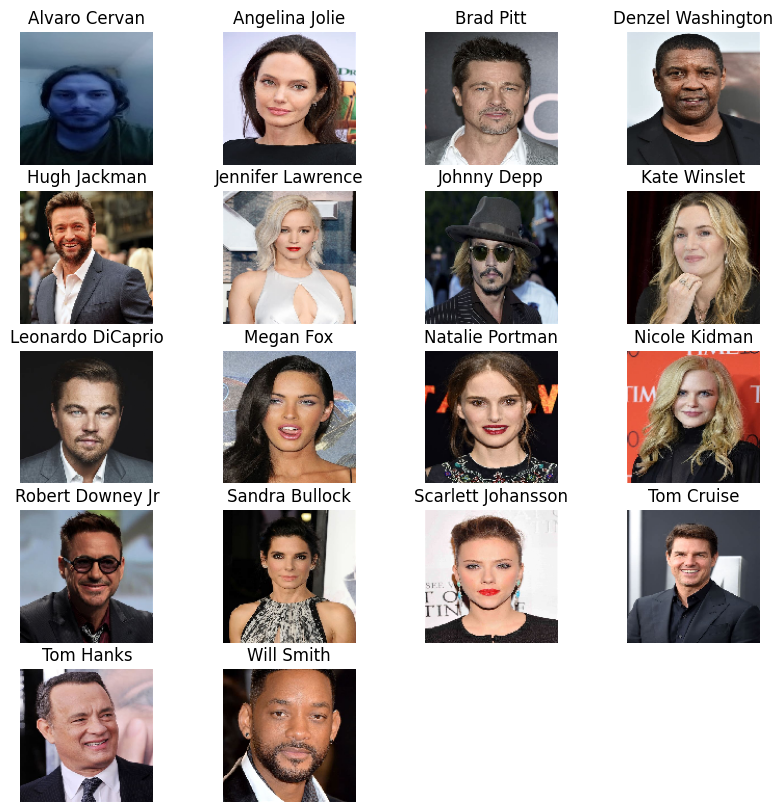

In [41]:
# print the first picture of each class with its label in a 5x4 grid
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
	plt.subplot(5, 4, i + 1)
	plt.imshow(data[labels == i][0])
	plt.title(classes[i])
	plt.axis("off")
plt.show()

### Feature extraction
The VGG16 model is used as a feature extractor to obtain high-level features from the images. The model is pre-trained on the ImageNet dataset and the top classification layer is removed. The extracted features are then used as input for the subsequent classification model.

In [30]:
# Feature extraction using VGG16
feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
feature_extractor.trainable = False
features = feature_extractor.predict(data, batch_size=32, verbose=1).reshape(len(data), -1)


69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 576ms/step


### Creating Training and Validation Subsets

In this step, we shuffle the extracted features and corresponding labels to ensure that the data is randomly distributed. We then split the data into training and validation sets with an 80-20 ratio. The training set is used to train the model, while the validation set is used to evaluate the model's performance during training.

We create TensorFlow datasets for both the training and validation sets, batching the data to the specified batch size and shuffling the training data to improve the model's generalization.

In [31]:
# Create shuffled training and validation datasets
data, labels = shuffle(features, labels, random_state=42)
split_idx = int(0.8 * len(data))
train_data, val_data = data[:split_idx], data[split_idx:]
train_labels, val_labels = labels[:split_idx], labels[split_idx:]

train_gen = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size).shuffle(len(train_data))
val_gen = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size)

### Model Building and Compilation

In this step, we build and compile the neural network model. The model consists of the following layers:

1. **Dense Layer**: A fully connected layer with 128 neurons and ReLU activation function.
2. **Dropout Layer**: A dropout layer with a dropout rate of 0.5 to prevent overfitting.
3. **Output Layer**: A fully connected layer with a number of neurons equal to the number of classes and a softmax activation function for multi-class classification.

The model is compiled using the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric.

In [32]:
# Build and compile the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(features.shape[1],)),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\advar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,051,026 (4.01 MB)

 Trainable params: 1,051,026 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=100)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2065 - loss: 2.7602 - val_accuracy: 0.2818 - val_loss: 2.2863
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2785 - loss: 2.2361 - val_accuracy: 0.2955 - val_loss: 2.1204
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3566 - loss: 1.9901 - val_accuracy: 0.3773 - val_loss: 1.9836
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3969 - loss: 1.8866 - val_accuracy: 0.4432 - val_loss: 1.8239
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4126 - loss: 1.7145 - val_accuracy: 0.4273 - val_loss: 1.7176
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4670 - loss: 1.5657 - val_accuracy: 0.4545 - val_loss: 1.6653
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5025 - loss: 1.4513 - val_accuracy: 0.4523 - val_loss: 1.5856
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5339 - loss: 1.3815 - val_accuracy: 0.4977 - v

### Accuracy and Loss
The model is trained for 100 epochs, and the training and validation accuracy and loss are plotted to evaluate the model's performance. The accuracy and loss curves show how well the model is learning the features and making predictions.

Seems like the model is overfitting the training data. We can try to improve the model by adding more regularization techniques like L2 regularization, dropout, or data augmentation.

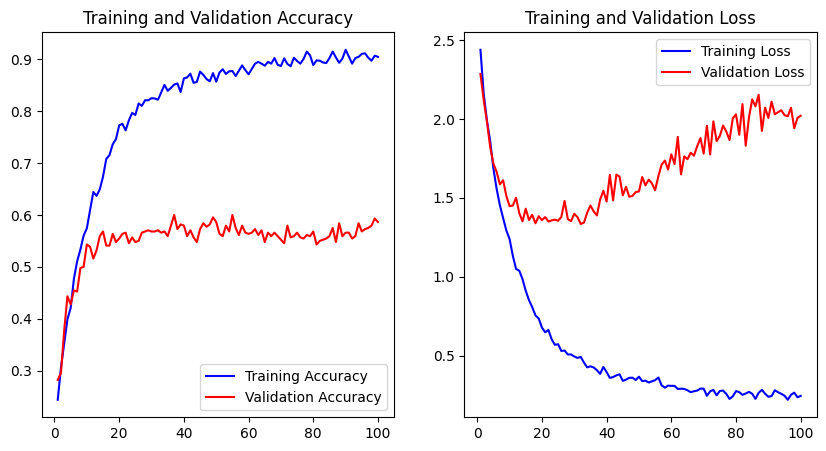

Model saved successfully.


In [34]:
# Plot training results
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the model with try-except block
modelname = "celebrity_face_classifierv47.keras"
try:
	model.save(modelname)
	print("Model saved successfully.")
except Exception as e:
	print(f"Failed to save the model: {e}")

### Evaluation
Confusion matrix is used to evaluate the model's performance on the validation set. The confusion matrix shows the number of correct and incorrect predictions for each class.

For what we can see on the diagonal, the model is doing a good job at classifying the validation images. However, there are some misclassifications in the off-diagonal elements.

We can also see how the validation elements are unevenly distributed across the classes.

We can also observer that the students images are the ones with the highest number of correct predictions. This could be explained as the data size is bigger than the other classes, that the images come from a video, so they are very similar leading to overfittingproblems or could be that the image manipulation is more favorable to the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


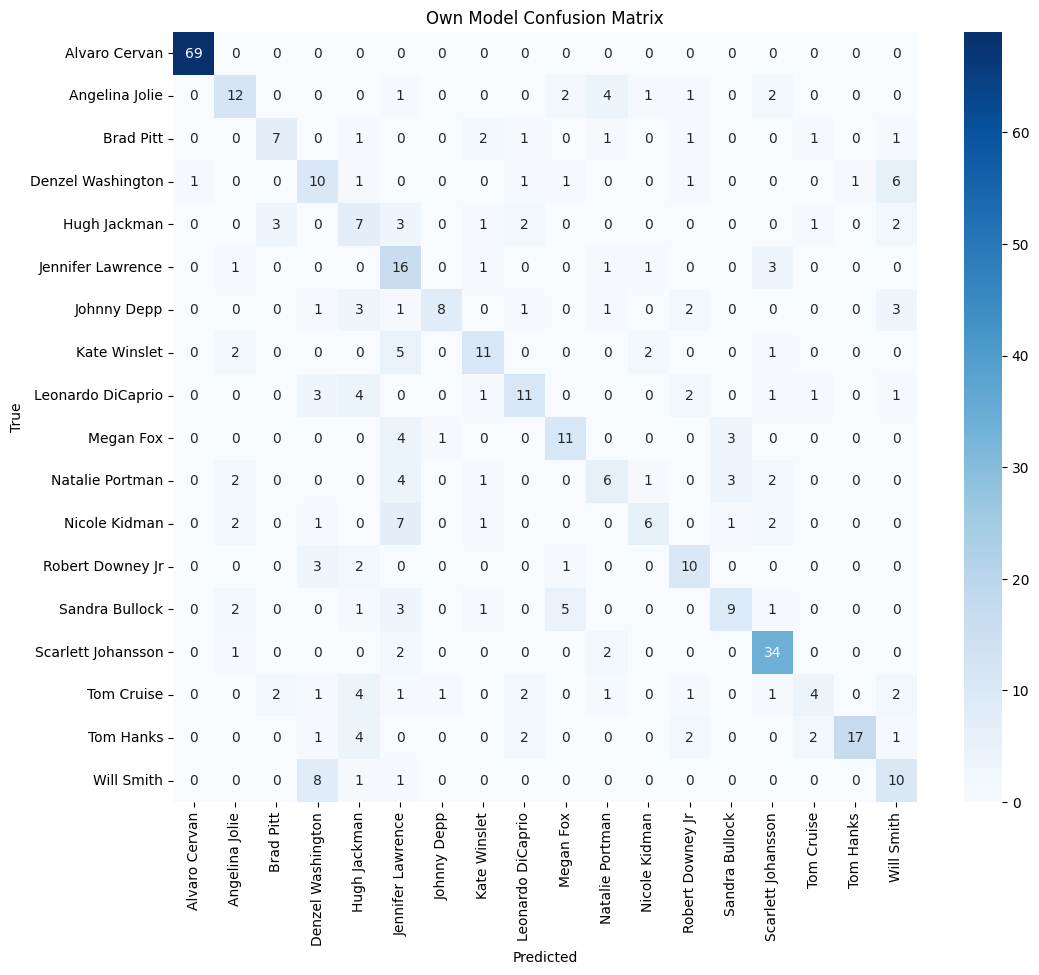

Model accuracy: 58.64%


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize lists to store true and predicted labels
true_labels = val_labels
predicted_labels = []

# Iterate through the validation data
for img_features, label in val_gen:
	predictions = model.predict(img_features)
	predicted_labels.extend(np.argmax(predictions, axis=1))

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
confusion_own = sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Own Model Confusion Matrix')
plt.show()

# calculate the accuracy of the model
accuracy_own = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f"Model accuracy: {accuracy_own * 100:.2f}%")

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Text(0.5, 1.0, 'Predicted class: Leonardo DiCaprio 41.60%')

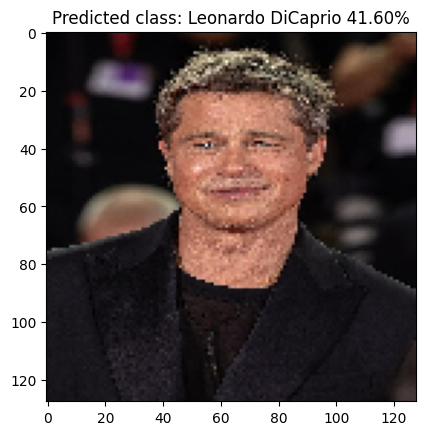

In [54]:
# Load the model
try:
	model = tf.keras.models.load_model(modelname)
	print("Model loaded successfully.")
except Exception as e:
	print(f"Failed to load the model: {e}")
	
# Test the model for a single image 
img_path = "actor1.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = img_array.reshape(1, *img_array.shape)
img_features = feature_extractor.predict(img_array).reshape(1, -1)
prediction = model.predict(img_features)
predicted_class = classes[np.argmax(prediction)]
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class} {prediction[0][np.argmax(prediction)] * 100:.2f}%")

## DeepFace Approach

This section is about the DeepFace approach to solve the problem. DeepFace is a deep learning model that is used to recognize faces in images. The model is trained on a large dataset of faces and learns to recognize faces by looking at the features of the face. The model is trained using a convolutional neural network (CNN) and is able to recognize faces with high accuracy.


In [47]:
from deepface import DeepFace


The library comes with a very useful function that allows us to use a sample image and compare it to a "database" of images (a folder with images) and return the matching images. This is very useful for our problem as we can use this function to compare the faces in the images and return the matching images.


In [ ]:
predictions = []
for file in os.listdir("celebrities"):
	print(file.split(".")[0])
	# compare the face of the file with the faces in the dataset and store the result in the predictions list
	dataset = DeepFace.find(img_path = "celebrities\\" + file, db_path = "Celebrity Faces Dataset\\" + file.split(".")[0], model_name = 'VGG-Face', enforce_detection = False)
	# store the result
	predictions.append(dataset[0]['identity'])

print(predictions)


In [ ]:
# save the results to a file
with open("predictions.txt", "w") as file:
	for prediction in predictions:
		for identity in prediction:
			file.write(identity + "\n")

# save the results to a file
with open("predictions2.csv", "w") as file:
	for prediction in predictions:
		for identity in prediction:
			file.write(identity + "\n")


### Validation
After comparing the sample images to the dataset images, we found 1619 images that matched the sample images out of 2197 total images. This means that the DeepFace model was able to recognize the faces in the images with an **accuracy of 73.7%**.

This is specially remarkable as some of the images are not very clear and the faces are not very visible.


In [38]:
# print the number of rows of predictions.txt
global t_predictions
t_predictions = 0
with open("predictions.txt", "r") as file:
	t_predictions = len(file.readlines())
print("Dataset Total Files:", t_predictions)

# print the number of .jpg files in the "Celebrity Faces Dataset" subfolders
count = 0
for folder in os.listdir("Celebrity Faces Dataset"):
	for file in os.listdir("Celebrity Faces Dataset\\" + folder):
		if file.endswith(".jpg"):
			count += 1
print("True Predictions: ", count)
print("Accuracy =", t_predictions / count  * 100, "%")


Dataset Total Files: 1619
True Predictions:  2197
Accuracy = 73.69139736003642 %


### Confusion Matrix

The confusion matrix is a bit special. It does not show the usual true positives, true negatives, false positives, and false negatives, basically giving us a perfect diagonal matrix with only true positives. This is because the DeepFace model is not a binary classifier, but a face recognition model that returns the images that match the sample images. Therefore, the confusion matrix shows the number of images that matched the sample images.


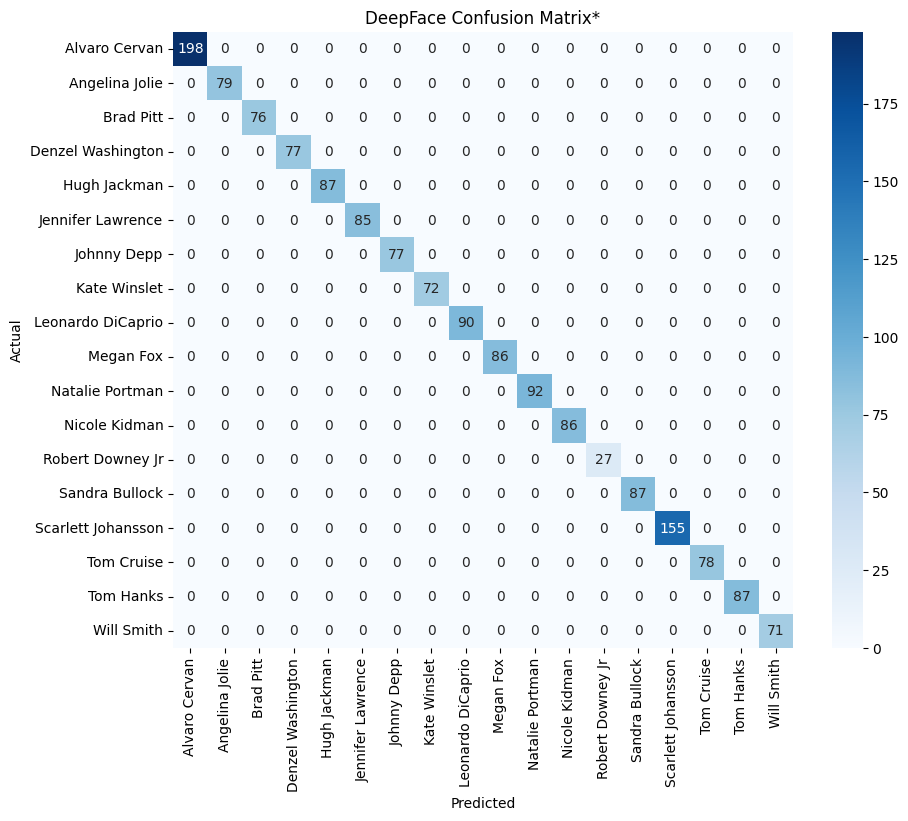

In [56]:
# Paths
predictions_file = "predictions.txt"
dataset_folder = "Celebrity Faces Dataset"

# Read predictions.txt
with open(predictions_file, "r") as f:
    predicted_files = set(line.strip() for line in f)

# Collect actual files and their classes
actual_classes = []
predicted_classes = []

# Iterate through the dataset folder
for class_name in os.listdir(dataset_folder):
    class_folder = os.path.join(dataset_folder, class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            actual_classes.append(class_name)
            # Check if the image is in the predictions.txt
            if image_path in predicted_files:
                predicted_classes.append(class_name)
            else:
                predicted_classes.append("None")  # No prediction

# Create confusion matrix
classes = sorted(os.listdir(dataset_folder))  # List of all classes
conf_matrix = confusion_matrix(actual_classes, predicted_classes, labels=classes)

# Print confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DeepFace Confusion Matrix*")
plt.show()

## SVM Model

This code trains a celebrity face recognition model using MTCNN, PCA, and SVM.

It loads images from the Celebrity Faces Dataset, detects faces using MTCNN, extracts and resizes them, then stores them with corresponding labels. The labels are then encoded numerically.

Next, it applies PCA to reduce dimensionality while preserving 95% of the variance. An SVM classifier is trained on these features and tested for accuracy.

Finally, the trained SVM model, PCA transformation, and label encoder are saved using joblib for future use.

In [58]:
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import os
import numpy as np
import tensorflow as tf

In [59]:
dataset_dir = r'Celebrity Faces Dataset'
celebrities = os.listdir(dataset_dir)

# Initialize MTCNN
detector = MTCNN()

# train  model using mtccn

# Load the dataset
images = []
labels = []
for celebrity in celebrities:
	celebrity_dir = os.path.join(dataset_dir, celebrity)
	for image_name in os.listdir(celebrity_dir):
		image_path = os.path.join(celebrity_dir, image_name)
		image = cv2.imread(image_path)
		if image is None:
			continue
		image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		faces = detector.detect_faces(image_rgb)
		if faces:
			x, y, width, height = faces[0]['box']
			face = image_rgb[y:y+height, x:x+width]
			face = cv2.resize(face, (160, 160))
			images.append(face)
			labels.append(celebrity)

images = np.array(images)
labels = np.array(labels)

# train model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC	
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Extract features using PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

# Train the model
model = SVC(kernel='linear')
model.fit(X_train_pca, y_train)

# Predict
y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Save the model
model_filename = 'celebrity_face_recognition_model.pkl'
pca_filename = 'pca.pkl'
label_encoder_filename = 'label_encoder.pkl'

import joblib

joblib.dump(model, model_filename)
joblib.dump(pca, pca_filename)
joblib.dump(label_encoder, label_encoder_filename)


Accuracy: 0.6601466992665037


['label_encoder.pkl']

### Confusion Matrix

With an accuracy of 66%, the SVM model performs well in recognizing celebrity faces. The confusion matrix shows a clear true positive diagonal, indicating that the model correctly identifies most celebrities. However, there are some misclassifications specially in actresses like Jeniffer Lawrence and Nikole Kidman. It is also interesting to see that the model has more trouble with actresses than actors, which could be due to the fact that the dataset has more images of actors than actresses.

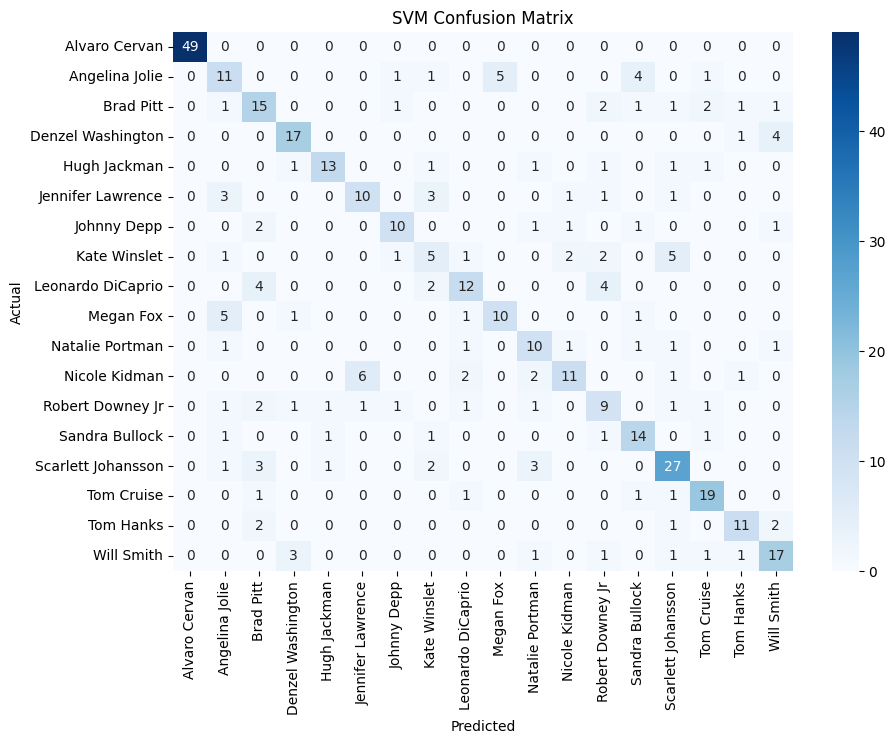

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()